In [21]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import scipy.signal as sig

dt = 0.05

DTMotor_A = np.mat('0,1; -0.552,1.52')
DTMotor_B = np.mat('0;1')
DTMotor_C = np.mat('0.00164,0.002')
DTMotor_D = np.mat('0')

A = np.mat('0,1; -0.552,1.52')
B = np.mat('0;1')
C = np.mat('0.00164,0.002')
D = np.mat('0')

import control as control
DTMotor_ss = control.ss(A,B,C,D, dt)
DTMotor_tf = control.ss2tf(DTMotor_ss)


In [22]:
print(DTMotor_tf)


 0.002 z + 0.00164
--------------------
z^2 - 1.52 z + 0.552

dt = 0.05



## Define PI controller system
- Input is 1D error signal $e(k)$
- The system is a dynamic system with state: $x(k) = \sum e(k)$
- Simple integral dynamics: x(k+1) = x(k) + e(k) 
- Output: $y(k) = K_i x(k) + K_p e(k)$

In [23]:
from pydrake.all import (BasicVector, LeafSystem, DiagramBuilder, Simulator, LogOutput, ConstantVectorSource, 
                         LinearSystem)

class DT_PISys(LeafSystem):
    def __init__(self,Kp, Ki,dt):
        LeafSystem.__init__(self)
        num_DTState = 1 
        num_input = 1
        num_output = 1
        self.Ki = Ki
        self.Kp = Kp
        # Define the state vector
        self.DeclareDiscreteState(num_DTState)
        # Define the input
        self.DeclareVectorInputPort("ref", BasicVector(1))
        self.DeclareVectorInputPort("motor_y", BasicVector(1))
        # Define the output
        self.DeclareVectorOutputPort("PI_y", BasicVector(num_output), self.CalcOutputY)
        self.DeclarePeriodicDiscreteUpdate(dt)           
        self.dt = dt
    def DoCalcDiscreteVariableUpdates(self, context, events, discrete_state):
        x = context.get_discrete_state_vector().CopyToVector()
        r = self.get_input_port(0).Eval(context)
        ym = self.get_input_port(1).Eval(context)
        xnext = x + self.dt*(r-ym)
        discrete_state.get_mutable_vector().SetFromVector(xnext)
        
    def CalcOutputY(self, context, output):
        x = context.get_discrete_state_vector().CopyToVector()
        r = self.get_input_port(0).Eval(context)
        ym = self.get_input_port(1).Eval(context)
        y = self.Ki*x + self.Kp * (r-ym)
        #y = r
        output.SetFromVector(y)


Text(0, 0.5, 'y(t)')

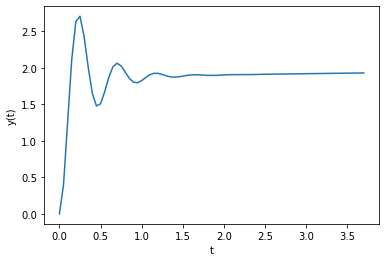

In [28]:
# Construct simulation and test the closed-loop behavior
ref = 2
Ki = 20
Kp = 100
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
stepInput = builder.AddSystem(ConstantVectorSource([ref]))  #step-input
PISys = builder.AddSystem(DT_PISys(Kp,Ki,dt))
MotorPlant = builder.AddSystem(LinearSystem(DTMotor_A,DTMotor_B,DTMotor_C,DTMotor_D,dt)) 
builder.Connect(PISys.get_output_port(0), MotorPlant.get_input_port(0))  #connect PI to motor
builder.Connect(stepInput.get_output_port(0), PISys.get_input_port(0))
builder.Connect(MotorPlant.get_output_port(0), PISys.get_input_port(1))  #feedback Motor measurement to PI

logger_output = LogOutput(MotorPlant.get_output_port(0), builder)
logger_input = LogOutput(PISys.get_output_port(0), builder)
diagram = builder.Build()

# setup simulator 
simulator = Simulator(diagram)
context = simulator.get_mutable_context()  #overall context

# now let's get subsystem context
PI_context = diagram.GetMutableSubsystemContext(PISys, context)
PI_context.SetDiscreteState([0])

Motor_context = diagram.GetMutableSubsystemContext(MotorPlant, context)
Motor_context.SetDiscreteState([0,0])

simulator.AdvanceTo(3.7)

# Plot the results.
plt.figure()
plt.plot(logger_output.sample_times(), logger_output.data().transpose())
#plt.plot(t,yout)
plt.xlabel('t')
plt.ylabel('y(t)')

## Now try the robust tracking design method (with full state)


In [39]:
Atilde = np.block([[DTMotor_A, np.zeros((2,1))], [-DTMotor_C, np.eye(1)]])
Btilde = np.vstack([DTMotor_B, 0])

#Mctilde= np.hstack([Btilde, Atilde*Btilde, Atilde*Atilde*Btilde])
#Mc = np.hstack([DTMotor_B, DTMotor_A*DTMotor_B])



import scipy.signal as sig

s_d = np.array([-3, -1+10*1j, -1-10*1j])
z_d = np.exp(s_d*dt)

fb = sig.place_poles(Atilde, Btilde, z_d)
Ktilde = fb.gain_matrix
print(Ktilde)

[[ 0.24156601 -0.01027269 -9.00318998]]


In [33]:
class TrackingControl(LeafSystem):
    def __init__(self,Ktilde,C,dt):
        LeafSystem.__init__(self)        
        self.Ktilde = Ktilde
        self.C = C
        # Define the state vector
        self.DeclareDiscreteState(1)
        # Define the input
        self.DeclareVectorInputPort("ref", BasicVector(1))
        self.DeclareVectorInputPort("plant_x", BasicVector(2))
        # Define the output
        self.DeclareVectorOutputPort("u", BasicVector(1), self.CalcOutputY)
        self.DeclarePeriodicDiscreteUpdate(dt)           
       
    def DoCalcDiscreteVariableUpdates(self, context, events, discrete_state):
        x = context.get_discrete_state_vector().CopyToVector()
        r = self.get_input_port(0).Eval(context)
        plant_x = self.get_input_port(1).Eval(context)
        plant_y = self.C@plant_x.reshape((2,1))
        xnext = x + (r-plant_y)
        discrete_state.get_mutable_vector().SetFromVector(xnext)
        
    def CalcOutputY(self, context, output):
        x = context.get_discrete_state_vector().CopyToVector()
        plant_x = self.get_input_port(1).Eval(context)
        xtilde= np.vstack([plant_x.reshape((2,1)),x])
        
        control_u  = self.Ktilde@xtilde
        
        output.SetFromVector(control_u)



Text(0, 0.5, 'y(t)')

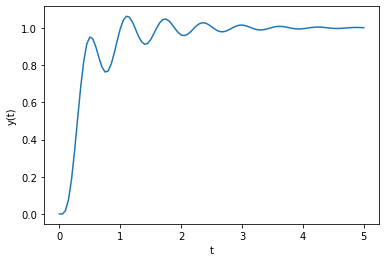

In [40]:

# Construct simulation and test the closed-loop behavior
ref = 1
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
stepInput = builder.AddSystem(ConstantVectorSource([ref]))  #step-input
tracker = builder.AddSystem(TrackingControl(-Ktilde, DTMotor_C, dt))

MotorPlant = builder.AddSystem(LinearSystem(DTMotor_A,DTMotor_B,np.eye(2),np.zeros((2,1)),dt)) 

builder.Connect(tracker.get_output_port(0), MotorPlant.get_input_port(0))  #connect tracking controller to plant
builder.Connect(stepInput.get_output_port(0), tracker.get_input_port(0))
builder.Connect(MotorPlant.get_output_port(0), tracker.get_input_port(1))  #feedback 

from pydrake.all import MatrixGain
output = builder.AddSystem(MatrixGain(DTMotor_C))
builder.Connect(MotorPlant.get_output_port(0), output.get_input_port(0))  

logger_output = LogOutput(output.get_output_port(0), builder)
#logger_input = LogOutput(tracker.get_output_port(0), builder)
diagram = builder.Build()

# setup simulator 
simulator = Simulator(diagram)
context = simulator.get_mutable_context()  #overall context

# now let's get subsystem context
tracker_context = diagram.GetMutableSubsystemContext(tracker, context)
tracker_context.SetDiscreteState([0])

Motor_context = diagram.GetMutableSubsystemContext(MotorPlant, context)
Motor_context.SetDiscreteState([0,0])

simulator.AdvanceTo(5)

ydata = logger_output.data().transpose()
# Plot the results.
plt.figure()
plt.plot(logger_output.sample_times(), logger_output.data().transpose())
#plt.plot(t,yout)
plt.xlabel('t')
plt.ylabel('y(t)')

In [ ]:
DTMotor_C


In [ ]:
np.linalg.matrix_rank(Mctilde)